
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

Cell 3:I'm going to explore the how the narrative/content related to the topic of inequality changed over time in the social media content. It refelcts the inequality issue from the different time period. 

## ***Why?***
<200 words

Cell 4: Inequality issue and the understanding about inequality is important in both the real world and the academic field. Through content analysis, we may detect the change of the focus of this important social issue in order to better understand the interaction of the social issue and the development of society.

## ***How?***
<400 words

Cell 5: We will use the topic modeling and word embedding to see the topic change over time.  

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words
We are going to use the NoW corpus to study this question. The virtue is this coropus is large for our analysis, covering a enough long time for us to check the topic change over time. The Limitation is there may some bias in the social media narratives.  
More intereting alternatives would be samples from Chinese social media to understand the inequality within the Chinese context.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

- I use the NoW corpus and filter the texts with the key word "inequality" in it. This is a rough selection of news related with "inequality", as not every news contained this word is talking about "inequality" related issue. So in future analysis, the selection criteria should be improved.   
- As I care about the topic change on the news related with "inequality" during the 2010 to 2019, for this homework, I only use the news in 2010 AND 2019 to make a simple comparison.  

- From the clustering results, we can see that for 2010 news, the clustering is more clearly separated, while 2019 news is less separated, in which the points and different topics are closely distributed. The silhouette_score is very low even if the number of clustering is high.  


- 

In [2]:
import lucem_illud
import zipfile
import pandas as pd
import os

In [3]:
corpora_address = "/Users/panrui/Desktop/MACSS/Content Analysis/Homework-Notes/data/now1"

In [4]:
now_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text-19-09.zip
text_10-06-bwq.zip
text-19-08.zip
text_10-11-weq.zip
text_10-08-lqd.zip
text_10-10-nln.zip
text_10-07-uek.zip
text_10-04-laq.zip
text_10-12-ixv.zip
text_10-03-ovi.zip
text_10-05-wbb.zip
text_10-02-kvz.zip
text-19-01.zip
text_10-01-kus.zip
text-19-03.zip
text-19-02.zip
text_10-09-udn.zip
text-19-06.zip
text-19-07.zip
text-19-05.zip
text-19-04.zip


In [106]:
def get_source(file_name):
    zfile = zipfile.ZipFile(corpora_address + file_name)
    source = []
    for file in zfile.namelist():
        with zfile.open(file) as f:
            for line in f:
                source.append(line)
    return source

In [107]:
def get_dict(source):
    
    now_txt_dict = {}
    now_dict = {}
    for news in source:
        news_str = news.decode("utf-8")
        if "inequality" in news_str:
            try:
                textID_title = news_str.split("<p>")[0].strip("@@")
                l_texts = news_str.split("<p>")[1:]
                if "<h>" in textID_title:
                    textID = textID_title.split("<h>")[0]
                    title = textID_title.split("<h>")[-1]
                else:
                    textID = textID_title
                now_txt_dict[textID.strip()] = " ".join(l_texts)
            except UnicodeDecodeError:
                continue
            if textID.strip() not in now_dict:
                now_dict[textID.strip()] = []
            if textID.strip() in now_dict:
                try:
                    now_dict[textID.strip()].append(now_texts[textID.strip()])
                except KeyError:
                    continue
    return now_txt_dict, now_dict

In [108]:
l_df1 = []
l_df2 = []
for zip_name in os.listdir(corpora_address):
    
    if zip_name != ".DS_Store":
        print(zip_name)
        if "text-19" in zip_name:
            source19 = get_source("/" + zip_name)
            nowtxtDict2 = get_dict(source19)[0]
            nowDF2 = pd.DataFrame(nowtxtDict2.items(), \
                                  columns = ['textID','texts'])
            l_df2.append(nowDF2)
        if "text_10" in zip_name:
            source10 = get_source("/" + zip_name)
            nowtxtDict1 = get_dict(source10)[0]
            nowDF1 = pd.DataFrame(nowtxtDict1.items(), \
                                  columns = ['textID','texts'])
            l_df1.append(nowDF1)
            

text-19-09.zip


KeyboardInterrupt: 

In [8]:
nowDF1 = l_df1[0]
for df in l_df1:
    nowDF1 = nowDF1.append(df)
nowDF2 = l_df2[0]
for df in l_df2:
    nowDF2 = nowDF2.append(df)

nowDF1["year"] = ["2010"]*len(nowDF1)
nowDF2["year"] = ["2019"]*len(nowDF2)

In [9]:
print("The number of news that mentioned inequality in 2010 is", len(nowDF1))
print("The number of news that mentioned inequality in 2019 is", len(nowDF2))

The number of news that mentioned inequality in 2010 is 980
The number of news that mentioned inequality in 2019 is 12573


In [109]:
nowDF1

,textID,texts,year,kmeans_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,1522186,"By Dale T. McKinley , Johannesburg June 15 ...",2010,3,"[By, Dale, T., McKinley, Johannesburg, June, 1...","[dale, t., mckinley, johannesburg, june, offer...","[june, offer, public, cup, collective, positiv..."
1,1525218,Julia Gillard Is Julia Gillard a conviction...,2010,3,"[Julia, Gillard, Is, Julia, Gillard, a, convic...","[julia, gillard, julia, gillard, conviction, p...","[simply, political, recent, centre, prime, min..."
2,1536821,If you 've been dead from the neck up this pa...,2010,1,"[If, you, ve, been, dead, from, the, neck, up,...","[have, dead, neck, past, week, come, shock, le...","[past, week, come, learn, australia, female, p..."
3,1541120,""" The MDC roots were in the popular challenge...",2010,3,"[The, MDC, roots, were, in, the, popular, chal...","[mdc, root, popular, challenge, zanu, pf, late...","[popular, challenge, late, movement, rest, jun..."
4,1520188,New Bedford - A law firm ran an ad for a fore...,2010,3,"[New, Bedford, A, law, firm, ran, an, ad, for,...","[new, bedford, law, firm, run, ad, foreclose, ...","[law, run, property, recently, state, white, p..."
...,...,...,...,...,...,...,...
91,1636971,2010-09-16 13:30 VinnyTheSaffer BEE - or ...,2010,3,"[2010, 09, 16, 13:30, VinnyTheSaffer, BEE, or,...","[13:30, vinnythesaffer, bee, correctly, bbbee,...","[base, black, know, corporate, help, black, pr..."
92,1636999,Trade union federation Cosatu has blamed the ...,2010,1,"[Trade, union, federation, Cosatu, has, blamed...","[trade, union, federation, cosatu, blame, anc,...","[trade, union, anc, policy, demand, south, afr..."
93,1641417,2010-09-20 18:13 Johannesburg - South Afric...,2010,1,"[2010, 09, 20, 18:13, Johannesburg, South, Afr...","[18:13, johannesburg, south, africa, easily, e...","[south, africa, poverty, president, say, south..."
94,1642959,"Jeremy Cronin , deputy general secretary of t...",2010,3,"[Jeremy, Cronin, deputy, general, secretary, o...","[jeremy, cronin, deputy, general, secretary, s...","[general, secretary, party, argue, case, anc, ..."


## 2010 news

In [10]:
# 2010
#First it needs to be initialized
ngCountVectorizer1 = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects1 = ngCountVectorizer1.fit_transform(nowDF1['texts'])
print(newsgroupsVects1.shape)
#initialize
newsgroupsTFTransformer1 = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects1)
#train
newsgroupsTF1 = newsgroupsTFTransformer1.transform(newsgroupsVects1)
print(newsgroupsTF1.shape)

(980, 46854)
(980, 46854)


In [11]:
list(zip(ngCountVectorizer1.vocabulary_.keys(), newsgroupsTF1.data))[10:30]

[('public', 0.008618282482398007),
 ('critique', 0.008909864113874899),
 ('of', 0.008102482078323307),
 ('the', 0.006552043367547375),
 ('fifa', 0.019344637205073827),
 ('soccer', 0.004819065828349922),
 ('world', 0.013331554644864319),
 ('cup', 0.003700529944029187),
 ('at', 0.007492912160748175),
 ('height', 0.01587540507232908),
 ('collective', 0.003942202822674658),
 ('frenzy', 0.011051124667630877),
 ('positive', 0.012528527764452891),
 ('expectation', 0.10283314610749894),
 ('feel', 0.008102482078323307),
 ('good', 0.026617404735004915),
 ('nationalism', 0.0443727848256839),
 ('and', 0.004057155055694239),
 ('general', 0.009742262137347687),
 ('excitement', 0.004844729254642536)]

In [12]:
#initialize
ngTFVectorizer1 = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects1 = ngTFVectorizer1.fit_transform(nowDF1['texts'])

In [13]:
nowDF1['texts']

0      By Dale T. McKinley , Johannesburg   June 15 ...
1      Julia Gillard   Is Julia Gillard a conviction...
2      If you 've been dead from the neck up this pa...
3      " The MDC roots were in the popular challenge...
4      New Bedford - A law firm ran an ad for a fore...
                            ...                        
91     2010-09-16 13:30   VinnyTheSaffer   BEE - or ...
92     Trade union federation Cosatu has blamed the ...
93     2010-09-20 18:13   Johannesburg - South Afric...
94     Jeremy Cronin , deputy general secretary of t...
95     Lawmakers , activists and world leaders are m...
Name: texts, Length: 980, dtype: object

Flat Clustering with K-means  
numClusters = 3

In [14]:
numClusters = 3
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects1)
nowDF1['kmeans_predictions'] = km.labels_

In [15]:
# look at the distinguishing features
terms1 = ngTFVectorizer1.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [16]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects1.toarray())
reduced_data1 = pca.transform(newsgroupsTFVects1.toarray())

components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms1[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
    Cluster 0: Cluster 1:   Cluster 2:
0       income      women        media
1        south        men         2015
2      poverty     gender          fox
3        state      woman         2016
4        india     female      matters
5         says        sex         beck
6    political       male         news
7       public     rights       reilly
8  development       says  celebrities
9        class   children   commenting


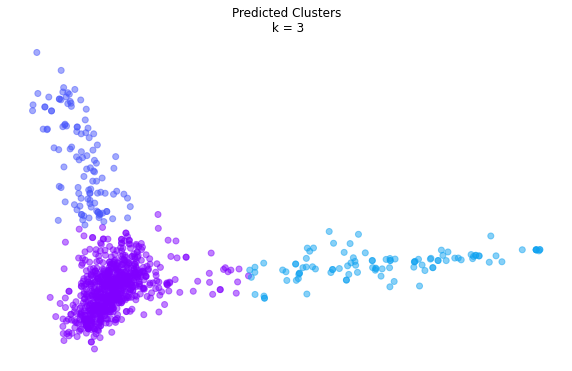

In [17]:
print("Top terms per cluster:")
table = pd.DataFrame()
for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms1[ind] for ind in order_centroids[i, :10]]
print(table)

colors = list(plt.cm.rainbow(np.linspace(0,1,10)))
colors_p = [colors[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()


Flat Clustering with K-means  
numClusters = 4

In [18]:
numClusters = 4
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects1)
nowDF1['kmeans_predictions'] = km.labels_

In [19]:
# look at the distinguishing features
terms1 = ngTFVectorizer1.get_feature_names()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects1.toarray())
reduced_data1 = pca.transform(newsgroupsTFVects1.toarray())

components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms1[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
  Cluster 0:   Cluster 1:   Cluster 2: Cluster 3:
0      women       income        media      south
1        men      poverty         2015      black
2     gender       growth          fox     africa
3     female        china         2016     school
4      woman      economy      matters       says
5        sex    countries         beck  political
6       male          tax         news      state
7     rights        india       reilly    schools
8   equality  development  celebrities     rights
9   violence       wealth   commenting   children


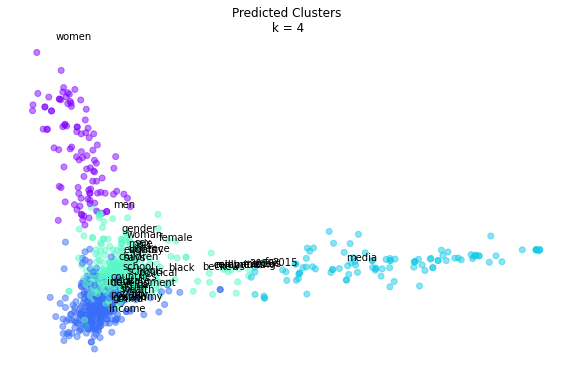

In [20]:
print("Top terms per cluster:")
table = pd.DataFrame()
for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms1[ind] for ind in order_centroids[i, :10]]
print(table)

colors = list(plt.cm.rainbow(np.linspace(0,1,8)))
colors_p = [colors[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.scatter(reduced_data1[:, 0], reduced_data1[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()


**Identify the optimal number of clusters**

In [21]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

In [22]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects1.toarray())
reduced_data = pca.transform(newsgroupsTFVects1.toarray())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


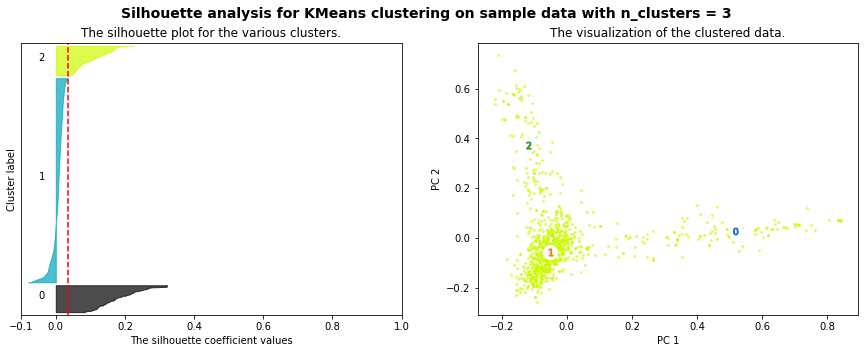

For n_clusters = 3, The average silhouette_score is : 0.035


In [23]:
X = newsgroupsTFVects1.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


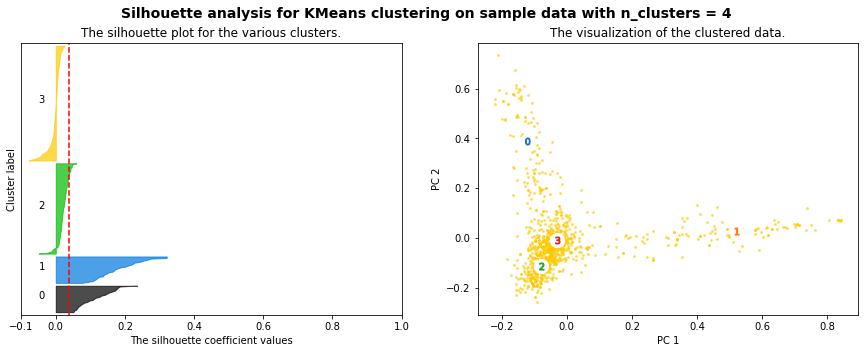

For n_clusters = 4, The average silhouette_score is : 0.037


In [24]:
X = newsgroupsTFVects1.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


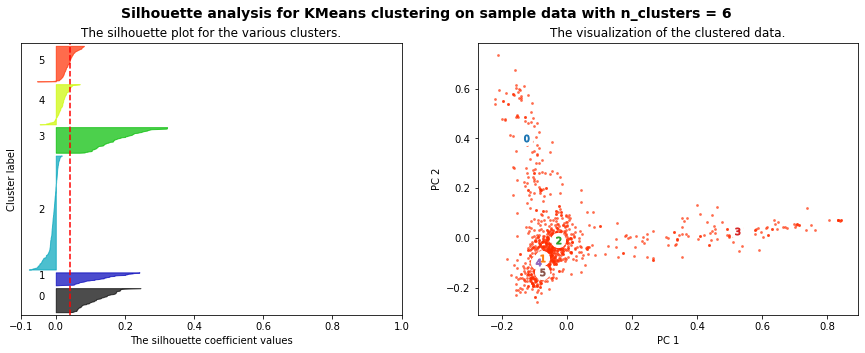

For n_clusters = 6, The average silhouette_score is : 0.040


In [25]:
X = newsgroupsTFVects1.toarray()
plotSilhouette(6, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


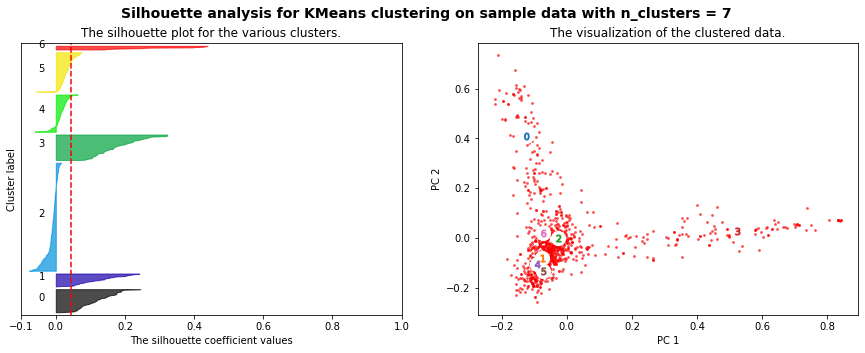

For n_clusters = 7, The average silhouette_score is : 0.043


In [26]:
X = newsgroupsTFVects1.toarray()
plotSilhouette(7, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


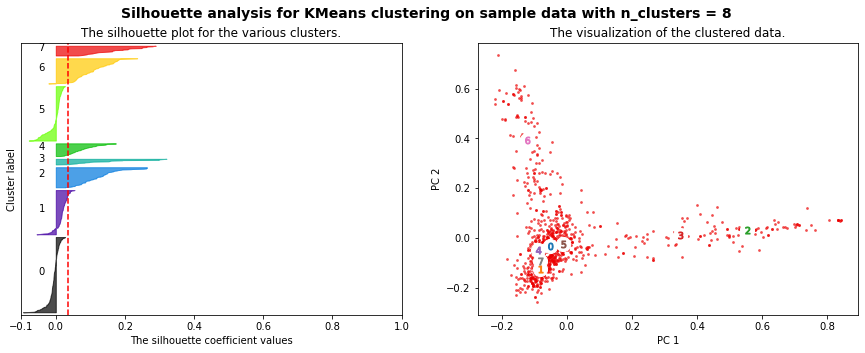

For n_clusters = 8, The average silhouette_score is : 0.036


In [27]:
X = newsgroupsTFVects1.toarray()
plotSilhouette(8, X)

- For the 2010 news, the optimal number of clusering is 7. The silhouette_score is largest at the n_clusters = 8.

## 2019 news

In [28]:
2019
#First it needs to be initialized
ngCountVectorizer9 = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects9 = ngCountVectorizer9.fit_transform(nowDF2['texts'])
print(newsgroupsVects9.shape)
#initialize
newsgroupsTFTransformer9 = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects9)
#train
newsgroupsTF9 = newsgroupsTFTransformer9.transform(newsgroupsVects9)
print(newsgroupsTF9.shape)

(12573, 136804)
(12573, 136804)


In [29]:
list(zip(ngCountVectorizer9.vocabulary_.keys(), newsgroupsTF9.data))[10:30]

[('of', 0.0114423302801821),
 ('the', 0.014222439940540645),
 ('work', 0.024277145025502652),
 ('asian', 0.016688997129596633),
 ('development', 0.014845337283140738),
 ('bank', 0.011626577369662364),
 ('adb', 0.0186000100637589),
 ('over', 0.03168148081496509),
 ('past', 0.017404042218963897),
 ('50', 0.01886386411779463),
 ('years', 0.020317195471752283),
 ('he', 0.029261825735741147),
 ('also', 0.028766954213978804),
 ('poses', 0.008158413899628143),
 ('questions', 0.04108427253702938),
 ('about', 0.03193341152448669),
 ('future', 0.012670116718783177),
 ('is', 0.01038134846975418),
 ('former', 0.01019508250543341),
 ('board', 0.09047570881235754)]

In [30]:
#initialize
ngTFVectorizer9 = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects9 = ngTFVectorizer9.fit_transform(nowDF2['texts'])

In [31]:
nowDF2['texts']

0        In his recent Interpreter post , Richard Moor...
1        A man from the small Western Pennsylvania tow...
2        As a leader of the Black Lives Matter movemen...
3        The Hollywood Reporter revealed today that ea...
4        HomeNewsEight experts on the risks and benefi...
                              ...                        
1412     25/04/2019 . Former President , Thabo Mbeki i...
1413     ON International Workers Day , Zimbabwe Lawye...
1414     JOHANNESBURG -- As the country gears up to ce...
1415     When South Africa held its first democratic e...
1416     Trade and Industry Minister Rob Davies is of ...
Name: texts, Length: 12573, dtype: object

Flat Clustering with K-means  
numClusters = 3

In [32]:
numClusters = 3
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects9)
nowDF2['kmeans_predictions'] = km.labels_

In [33]:
# look at the distinguishing features
terms9 = ngTFVectorizer1.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [34]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects9.toarray())
reduced_data9 = pca.transform(newsgroupsTFVects9.toarray())

components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms9[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
   Cluster 0: Cluster 1: Cluster 2:
0       woman       soon        tax
1     funding        ago    dollars
2  management      argue  situation
3         far   question       idea
4        gave      agree    project
5         end        aid     person
6    violence  political  political
7          wo    dollars      words
8       words    opinion       true
9          ll  statement  statement


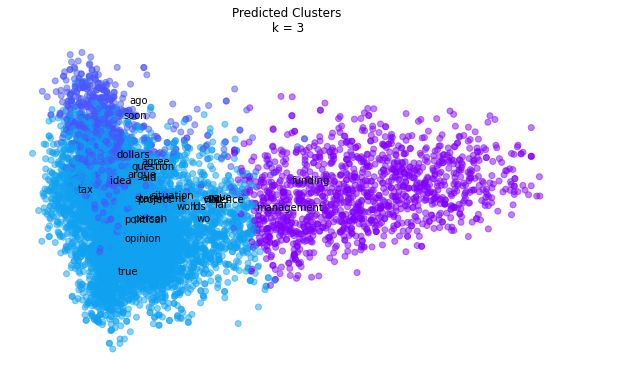

In [35]:
print("Top terms per cluster:")
table = pd.DataFrame()
for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms9[ind] for ind in order_centroids[i, :10]]
print(table)

colors = list(plt.cm.rainbow(np.linspace(0,1,10)))
colors_p = [colors[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.scatter(reduced_data9[:, 0], reduced_data9[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()


Flat Clustering with K-means  
numClusters = 5

In [36]:
numClusters = 5
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects9)
nowDF2['kmeans_predictions'] = km.labels_

In [37]:
# look at the distinguishing features
terms9 = ngTFVectorizer1.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [38]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects9.toarray())
reduced_data9 = pca.transform(newsgroupsTFVects9.toarray())

components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms9[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Top terms per cluster:
  Cluster 0: Cluster 1:    Cluster 2: Cluster 3:  Cluster 4:
0       true       soon           tax    dollars       woman
1    opinion        ago        wealth      early     funding
2  political      argue          idea    deficit  management
3     person   question         taxes  situation         far
4     degree      agree  organization       good        gave
5      claim        aid         quite       idea         end
6      thing  political   republicans     groups    violence
7   required    dollars         cases      point       words
8         bp    opinion       wealthy     gender          wo
9  statement  statement         books     reform          ll


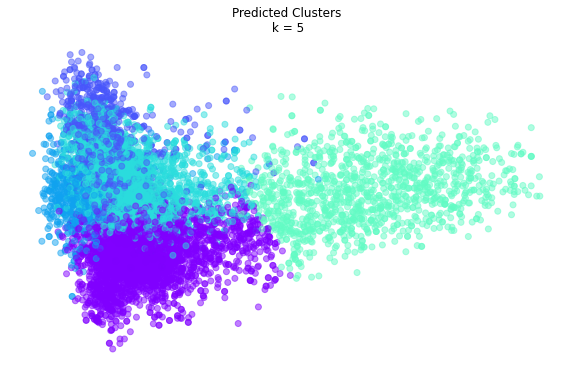

In [39]:
print("Top terms per cluster:")
table = pd.DataFrame()
for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms9[ind] for ind in order_centroids[i, :10]]
print(table)

colors = list(plt.cm.rainbow(np.linspace(0,1,10)))
colors_p = [colors[l] for l in km.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

plt.scatter(reduced_data9[:, 0], reduced_data9[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5')
plt.show()


**Identify the optimal number of clusters**

In [40]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects9.toarray())
reduced_data = pca.transform(newsgroupsTFVects9.toarray())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


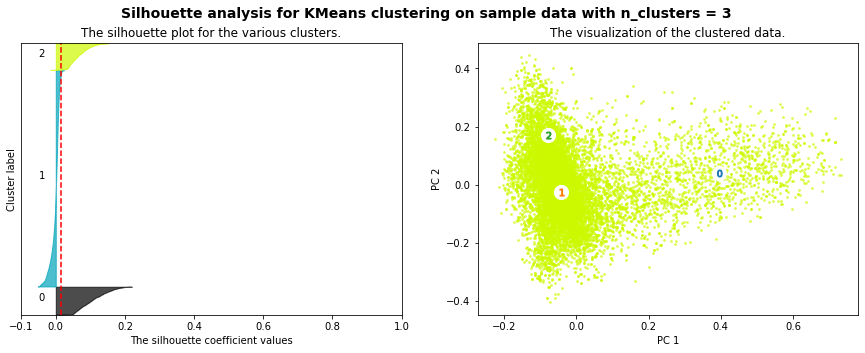

For n_clusters = 3, The average silhouette_score is : 0.016


In [41]:
X = newsgroupsTFVects9.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


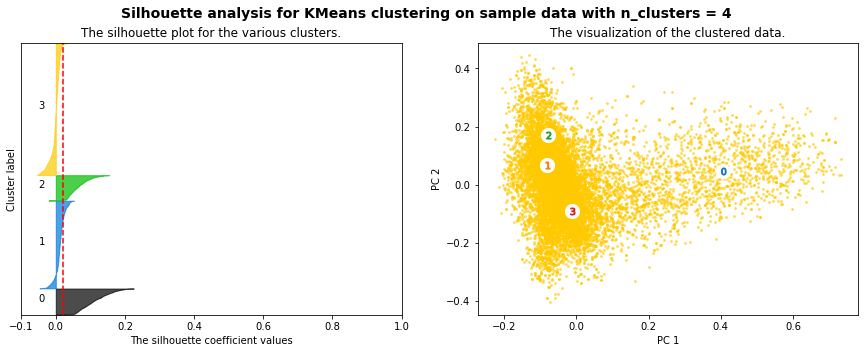

For n_clusters = 4, The average silhouette_score is : 0.019


In [42]:
X = newsgroupsTFVects9.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


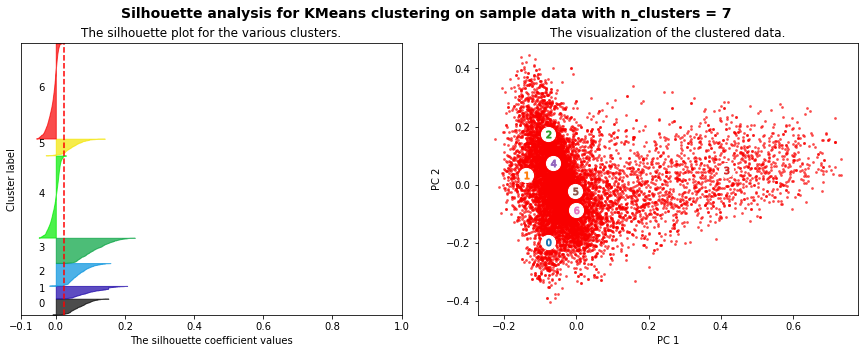

For n_clusters = 7, The average silhouette_score is : 0.023


In [43]:
X = newsgroupsTFVects9.toarray()
plotSilhouette(7, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


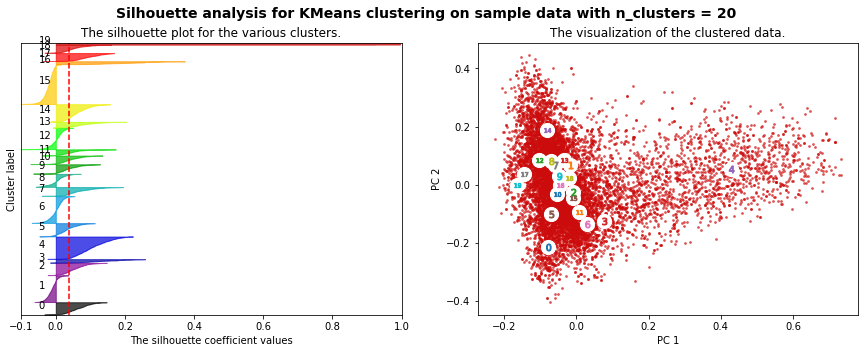

For n_clusters = 20, The average silhouette_score is : 0.037


In [112]:
X = newsgroupsTFVects9.toarray()
plotSilhouette(20, X)

- Even if the number of clustering is very high, the silhouette_score is still low, and keeps increasing with the number of clustering. 
- Compared to the 2010 news, it seems that the 2019 news related to inequality is harder to cluster. 
- While on the other hand, it also might be the problem of the method to filter news related with "inequality", which is only based on whether containing the keyword "inequality".

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

- Again, we use the news in 2010 and 2019 to do the same analysis separately.

In [45]:
newsgroupsTFVects1[:100].todense()
newsgroupsCoocMat1 = newsgroupsTFVects1 * newsgroupsTFVects1.T
newsgroupsCoocMat1.setdiag(0)

In [46]:
subCoocMat1 = newsgroupsCoocMat1[:100, :100]
linkage_matrix1 = scipy.cluster.hierarchy.ward(subCoocMat1.toarray())

/Applications/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


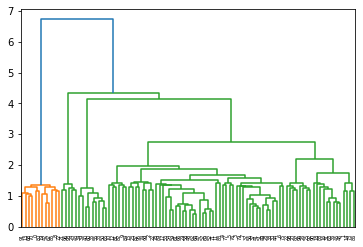

In [47]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix1, get_leaves=True)

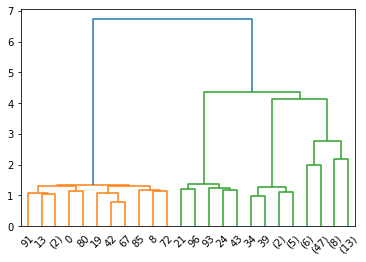

In [48]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix1, p=4, truncate_mode='level', get_leaves=True)

In [49]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat1.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 
                                                             4, 'maxclust')

In [50]:
print("For our 2010 news corpus clusters (compare KMeans and Hierarchical clusters):")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(nowDF1['kmeans_predictions'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(nowDF1['kmeans_predictions'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(nowDF1['kmeans_predictions'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(nowDF1['kmeans_predictions'], hierarchicalClusters_full)))


For our 2010 news corpus clusters (compare KMeans and Hierarchical clusters):
Homogeneity: 0.444
Completeness: 0.524
V-measure: 0.481
Adjusted Rand Score: 0.317


In [51]:
newsgroupsTFVects9[:100].todense()
newsgroupsCoocMat9 = newsgroupsTFVects9 * newsgroupsTFVects9.T
newsgroupsCoocMat9.setdiag(0)

/Applications/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [52]:
subCoocMat9 = newsgroupsCoocMat9[:100, :100]
linkage_matrix9 = scipy.cluster.hierarchy.ward(subCoocMat9.toarray())

/Applications/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


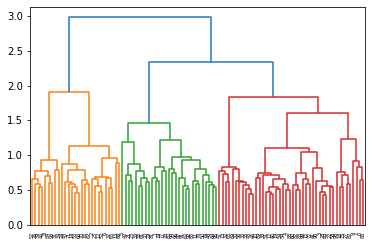

In [53]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix9, get_leaves=True)

In [54]:
print("For our 2019 news corpus clusters (compare KMeans and Hierarchical clusters):")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(nowDF2['kmeans_predictions'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(nowDF2['kmeans_predictions'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(nowDF2['kmeans_predictions'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(nowDF2['kmeans_predictions'], hierarchicalClusters_full)))


For our 2019 news corpus clusters (compare KMeans and Hierarchical clusters):


ValueError: Found input variables with inconsistent numbers of samples: [12573, 980]

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [55]:
nowDF1['tokenized_text'] = nowDF1['texts'].apply(lambda x: lucem_illud.word_tokenize(x))
nowDF1['normalized_tokens'] = nowDF1['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [56]:
nowDF1[::20]

,textID,texts,year,kmeans_predictions,tokenized_text,normalized_tokens
0,1522186,"By Dale T. McKinley , Johannesburg June 15 ...",2010,3,"[By, Dale, T., McKinley, Johannesburg, June, 1...","[dale, t., mckinley, johannesburg, june, offer..."
20,1513640,Why do governments in India refuse to accept ...,2010,1,"[Why, do, governments, in, India, refuse, to, ...","[government, india, refuse, accept, mass, maln..."
40,1512509,Woods has acknowledged his membership in the ...,2010,2,"[Woods, has, acknowledged, his, membership, in...","[wood, acknowledge, membership, league, south,..."
60,1534418,There 's an episode of the classic ( if under...,2010,2,"[There, 's, an, episode, of, the, classic, if,...","[episode, classic, underappreciated, hbo, sket..."
8,1509357,Here we go again . The drumbeat of negativity...,2010,3,"[Here, we, go, again, The, drumbeat, of, negat...","[drumbeat, negativity, start, soon, heavy, she..."
28,1532500,Aranui Theatre Company is the brainchild of c...,2010,3,"[Aranui, Theatre, Company, is, the, brainchild...","[aranui, theatre, company, brainchild, celebra..."
48,1521099,A legal system can not demand the faith and f...,2010,3,"[A, legal, system, can, not, demand, the, fait...","[legal, system, demand, faith, fealty, govern,..."
68,1524017,Thousands of people staged a march on Wednesd...,2010,3,"[Thousands, of, people, staged, a, march, on, ...","[thousand, people, stage, march, wednesday, pr..."
16,1717044,Arab women possess the DNA of social change ....,2010,0,"[Arab, women, possess, the, DNA, of, social, c...","[arab, woman, possess, dna, social, change, eg..."
36,4521095,IT 'S a small institute charged with the huge...,2010,0,"[IT, 'S, a, small, institute, charged, with, t...","[small, institute, charge, huge, responsibilit..."


In [57]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

nowDF1['reduced_tokens'] = nowDF1['normalized_tokens'].apply(lambda x: dropMissing(x, ngTFVectorizer1.vocabulary_.keys()))


In [58]:
dictionary1 = gensim.corpora.Dictionary(nowDF1['reduced_tokens'])
corpus1 = [dictionary1.doc2bow(text) for text in nowDF1['reduced_tokens']]

In [59]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus1)
senmm = gensim.corpora.MmCorpus('senate.mm')

In [60]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary1, num_topics=10, alpha='auto', eta='auto')

In [61]:
sen1Bow = dictionary1.doc2bow(nowDF1['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]

TypeError: decoding to str: need a bytes-like object, list found

In [62]:
nowDF1

,textID,texts,year,kmeans_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,1522186,"By Dale T. McKinley , Johannesburg June 15 ...",2010,3,"[By, Dale, T., McKinley, Johannesburg, June, 1...","[dale, t., mckinley, johannesburg, june, offer...","[june, offer, public, cup, collective, positiv..."
1,1525218,Julia Gillard Is Julia Gillard a conviction...,2010,3,"[Julia, Gillard, Is, Julia, Gillard, a, convic...","[julia, gillard, julia, gillard, conviction, p...","[simply, political, recent, centre, prime, min..."
2,1536821,If you 've been dead from the neck up this pa...,2010,1,"[If, you, ve, been, dead, from, the, neck, up,...","[have, dead, neck, past, week, come, shock, le...","[past, week, come, learn, australia, female, p..."
3,1541120,""" The MDC roots were in the popular challenge...",2010,3,"[The, MDC, roots, were, in, the, popular, chal...","[mdc, root, popular, challenge, zanu, pf, late...","[popular, challenge, late, movement, rest, jun..."
4,1520188,New Bedford - A law firm ran an ad for a fore...,2010,3,"[New, Bedford, A, law, firm, ran, an, ad, for,...","[new, bedford, law, firm, run, ad, foreclose, ...","[law, run, property, recently, state, white, p..."
...,...,...,...,...,...,...,...
91,1636971,2010-09-16 13:30 VinnyTheSaffer BEE - or ...,2010,3,"[2010, 09, 16, 13:30, VinnyTheSaffer, BEE, or,...","[13:30, vinnythesaffer, bee, correctly, bbbee,...","[base, black, know, corporate, help, black, pr..."
92,1636999,Trade union federation Cosatu has blamed the ...,2010,1,"[Trade, union, federation, Cosatu, has, blamed...","[trade, union, federation, cosatu, blame, anc,...","[trade, union, anc, policy, demand, south, afr..."
93,1641417,2010-09-20 18:13 Johannesburg - South Afric...,2010,1,"[2010, 09, 20, 18:13, Johannesburg, South, Afr...","[18:13, johannesburg, south, africa, easily, e...","[south, africa, poverty, president, say, south..."
94,1642959,"Jeremy Cronin , deputy general secretary of t...",2010,3,"[Jeremy, Cronin, deputy, general, secretary, o...","[jeremy, cronin, deputy, general, secretary, s...","[general, secretary, party, argue, case, anc, ..."


In [65]:
ldaDF = pandas.DataFrame({
        'ID' : nowDF1['textID'],
        'topics' : [senlda[dictionary1.doc2bow(l)] for l in nowDF1['reduced_tokens']]
    })

In [66]:
ldaDF

,ID,topics
0,1522186,"[(0, 0.057843223), (1, 0.59416634), (2, 0.0474..."
1,1525218,"[(2, 0.96894675), (8, 0.018941654)]"
2,1536821,"[(1, 0.06810242), (2, 0.013703597), (3, 0.0132..."
3,1541120,"[(1, 0.013976813), (2, 0.05958194), (5, 0.0555..."
4,1520188,"[(3, 0.042363804), (6, 0.29289654), (8, 0.6564..."
...,...,...
91,1636971,"[(0, 0.16781557), (1, 0.23182768), (2, 0.06880..."
92,1636999,"[(1, 0.6398169), (5, 0.087171584), (6, 0.26178..."
93,1641417,"[(6, 0.040579144), (8, 0.9410002)]"
94,1642959,"[(1, 0.035761476), (6, 0.90054893), (8, 0.0373..."


In [67]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,ID,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,1525218,"[(2, 0.96894675), (8, 0.018941654)]",0.000000,0.000000,0.968947,0.000000,0.000000,0.000000,0.000000,0.000000,0.018942,0.000000
29,1522535,"[(1, 0.2032462), (6, 0.018031962), (8, 0.72274...",0.000000,0.203246,0.000000,0.000000,0.000000,0.000000,0.018032,0.000000,0.722744,0.052140
57,1712854,"[(1, 0.15027307), (5, 0.16575485), (6, 0.01654...",0.000000,0.150273,0.000000,0.000000,0.000000,0.165755,0.016544,0.665107,0.000000,0.000000
79,1615176,"[(1, 0.22093052), (5, 0.019431004), (8, 0.5477...",0.000000,0.220931,0.000000,0.000000,0.000000,0.019431,0.000000,0.000000,0.547705,0.205812
11,1575782,"[(0, 0.0983177), (1, 0.1859353), (3, 0.2899311...",0.098318,0.185935,0.000000,0.289931,0.000000,0.000000,0.090022,0.000000,0.194219,0.130135
23,1441570,"[(0, 0.070937745), (1, 0.061993074), (2, 0.054...",0.070938,0.061993,0.054571,0.000000,0.015021,0.065841,0.107488,0.000000,0.622356,0.000000
49,1754032,"[(3, 0.23871697), (4, 0.123175055), (5, 0.1962...",0.000000,0.000000,0.000000,0.238717,0.123175,0.196271,0.000000,0.439056,0.000000,0.000000
12,1490791,"[(0, 0.013856844), (4, 0.98094773)]",0.013857,0.000000,0.000000,0.000000,0.980948,0.000000,0.000000,0.000000,0.000000,0.000000
43,1375933,"[(1, 0.95858043), (7, 0.036050204)]",0.000000,0.958580,0.000000,0.000000,0.000000,0.000000,0.000000,0.036050,0.000000,0.000000
17,1624362,"[(0, 0.075553656), (2, 0.2785856), (3, 0.31844...",0.075554,0.000000,0.278586,0.318442,0.089221,0.000000,0.050471,0.091293,0.000000,0.087441


In [68]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['ID']]
#ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVis = ldaDFV.values
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.057843,0.594166,0.047405,0.000000,0.000000,0.010374,0.079142,0.000000,0.110925,0.091581
1,0.000000,0.000000,0.968947,0.000000,0.000000,0.000000,0.000000,0.000000,0.018942,0.000000
2,0.000000,0.068102,0.013704,0.013237,0.772098,0.000000,0.062705,0.000000,0.029123,0.035560
3,0.000000,0.013977,0.059582,0.000000,0.000000,0.055592,0.016964,0.747450,0.087663,0.000000
4,0.000000,0.000000,0.000000,0.042364,0.000000,0.000000,0.292897,0.000000,0.656416,0.000000
5,0.000000,0.061446,0.923660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.185416,0.000000,0.000000,0.064776,0.000000,0.000000,0.639067,0.000000,0.097016,0.000000
7,0.000000,0.000000,0.187878,0.000000,0.713022,0.088542,0.000000,0.000000,0.000000,0.000000
8,0.282543,0.223226,0.000000,0.000000,0.000000,0.000000,0.136965,0.000000,0.354744,0.000000
9,0.097316,0.000000,0.000000,0.710693,0.000000,0.100272,0.000000,0.030937,0.000000,0.057547


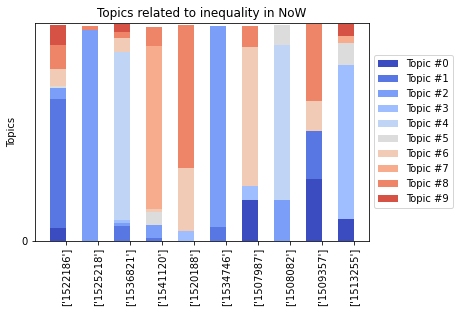

In [69]:
# visulization
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    
plt.ylim((0, 1))  
plt.ylabel('Topics')

plt.title('Topics related to inequality in NoW')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

<ipython-input-70-3652064bcbe2>:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Blues')


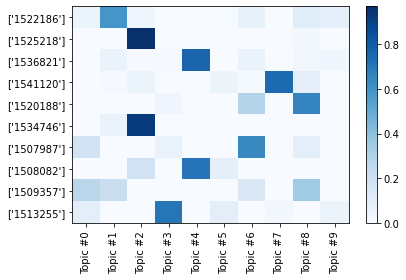

In [70]:
# Heatmap
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()
# rotate the ticks on the x-axis
plt.xticks(rotation=90)
# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [71]:
senlda.show_topic(7) # topic top words

[('say', 0.010112027),
 ('state', 0.008214726),
 ('live', 0.006307033),
 ('group', 0.0059704822),
 ('support', 0.0059285304),
 ('woman', 0.0057506124),
 ('come', 0.0054793796),
 ('high', 0.0052532814),
 ('know', 0.0052511254),
 ('look', 0.0052288547)]

In [72]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,woman,say,say,say,woman,state,state,say,say,woman
1,man,state,woman,woman,think,school,say,state,income,say
2,say,woman,child,state,say,say,high,live,political,state
3,state,black,state,think,man,obama,society,group,national,think
4,child,live,live,school,state,think,think,support,live,man
5,know,house,war,know,know,high,support,woman,policy,live
6,think,poor,think,law,come,income,south,come,state,pay
7,come,know,man,change,live,policy,change,high,south,problem
8,high,south,want,society,thing,change,policy,know,poverty,increase
9,political,change,change,human,change,public,political,look,day,income


<Figure size 432x288 with 0 Axes>

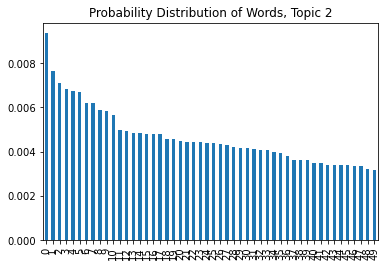

In [74]:
topic1_df = pandas.DataFrame(senlda.show_topic(2, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 2')
plt.show()

In [98]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary1, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary1, num_topics=10, eta = 0.9)

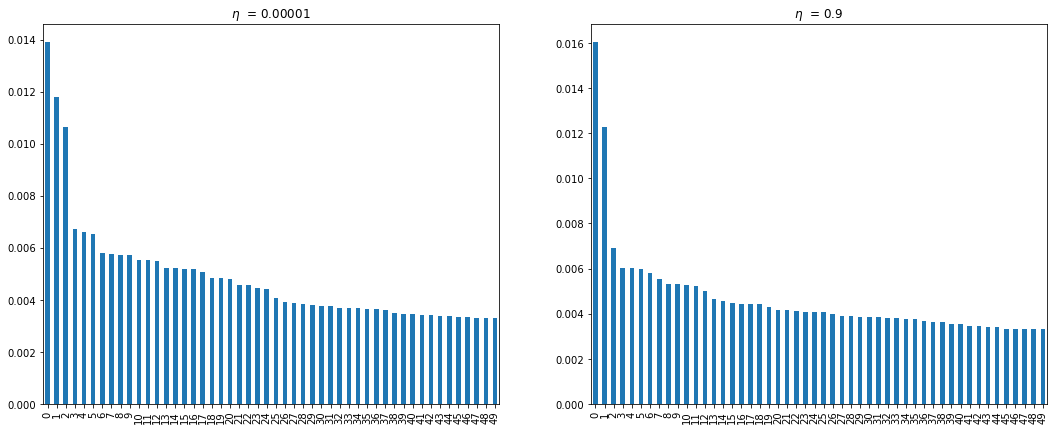

In [99]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [115]:
corpora_address = "/Users/panrui/Desktop/MACSS/Content Analysis/Homework-Notes/data/SOAP"


In [116]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [59]:
import zipfile
import pandas as pd

In [60]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [61]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [69]:
source

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [62]:
soap_dict = {}

In [112]:
for soap in source[3:10]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            print(textID,soap_texts[textID])
            print(soap_texts[7])
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

7 ['@!Reporter', 'Is', 'there', 'anything', 'you', 'regret', 'from', 'this', 'experience', '@!David', 'On', 'TV', 'Well', 'I', 'guess', 'if', 'there', "'s", 'anything', 'I', 'regret', 'it', "'s", 'the', 'fact', 'that', 'I', 'was', 'kept', 'away', 'from', 'most', 'of', 'my', 'patients', 'who', 'really', 'need', 'me', '@!Reporter', 'And', 'how', 'do', 'you', 'see', 'your', 'future', 'from', 'here', 'on', '@!David', 'On', 'TV', 'Well', 'most', 'of', 'my', 'adult', 'life', 'has', 'been', 'dedicated', 'towards', 'healing', 'so', 'now', 'that', 'I', "'ve", 'been', 'totally', 'exonerated', 'I', "'m", 'looking', 'forward', 'to', 'getting', 'back', 'to', 'that', 'at', 'the', 'earliest', 'opportunity', 'I', 'mean', 'this', 'has', 'been', 'a', 'very', 'sad', 'and', 'disturbing', 'chapter', 'in', 'my', 'life', 'And', 'I', 'just', 'want', 'people', 'to', 'know', 'that', 'I', 'hold', 'no', 'ill', 'will', 'or', 'malice', 'towards', 'those', 'who', 'falsely', 'accused', 'me', '@!Tad', 'Falsely', 'accu

In [71]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [95]:
n=0
while n <1:
    for v in soap_dict.values():
        print(type(v))
        print(v[0])
        n+=1

<class 'list'>
['@!Reporter', 'Is', 'there', 'anything', 'you', 'regret', 'from', 'this', 'experience', '@!David', 'On', 'TV', 'Well', 'I', 'guess', 'if', 'there', "'s", 'anything', 'I', 'regret', 'it', "'s", 'the', 'fact', 'that', 'I', 'was', 'kept', 'away', 'from', 'most', 'of', 'my', 'patients', 'who', 'really', 'need', 'me', '@!Reporter', 'And', 'how', 'do', 'you', 'see', 'your', 'future', 'from', 'here', 'on', '@!David', 'On', 'TV', 'Well', 'most', 'of', 'my', 'adult', 'life', 'has', 'been', 'dedicated', 'towards', 'healing', 'so', 'now', 'that', 'I', "'ve", 'been', 'totally', 'exonerated', 'I', "'m", 'looking', 'forward', 'to', 'getting', 'back', 'to', 'that', 'at', 'the', 'earliest', 'opportunity', 'I', 'mean', 'this', 'has', 'been', 'a', 'very', 'sad', 'and', 'disturbing', 'chapter', 'in', 'my', 'life', 'And', 'I', 'just', 'want', 'people', 'to', 'know', 'that', 'I', 'hold', 'no', 'ill', 'will', 'or', 'malice', 'towards', 'those', 'who', 'falsely', 'accused', 'me', '@!Tad', 'Fa

In [72]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [73]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [75]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [76]:
dool = soap_df['Tokenized Texts'][9]

In [77]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [78]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [79]:
import networkx as nx

In [80]:
actor_network = nx.Graph()

In [81]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [82]:
i = 0

In [83]:
all_texts = []

In [85]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

KeyboardInterrupt: 

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

Networks

In [75]:
import networkx as nx

In [79]:
nowDF = nowDF1[:100]

In [80]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [81]:
g = wordCooccurrence(nowDF['normalized_tokens'].sum())

In [82]:
print('Total number of vertices: ',len(g.nodes))
print('Total number of edges: ', len(g.edges))

Total number of vertices:  58
Total number of edges:  876


In [83]:
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

bVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence = bVectorizer.fit_transform(nowDF['texts'])
bVects_incidence

<100x9757 sparse matrix of type '<class 'numpy.int64'>'
	with 49694 stored elements in Compressed Sparse Row format>

In [84]:
g = nx.Graph()
g.add_nodes_from((bVectorizer.get_feature_names()[i] for i in range(bVects_incidence.shape[1])), bipartite = 'word')
g.add_nodes_from(range(bVects_incidence.shape[0]), bipartite = 'doc')
g.add_edges_from(((d, bVectorizer.get_feature_names()[w], {'weight' : bVects_incidence[d, w]}) 
                          for d, w in zip(*bVects_incidence.nonzero())))

def contractNetwork_all(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

g_word = contractNetwork_all(g, 'word')
g_word.remove_edges_from([(n1, n2) for n1, n2, d in g_word.edges(data = True) if d['weight'] <= 20])
g_word.remove_nodes_from(list(nx.isolates(g)))

In [85]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
giant = max(connected_component_subgraphs(g_word), key=len)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 468
Number of edges: 18496
Average degree:  79.0427


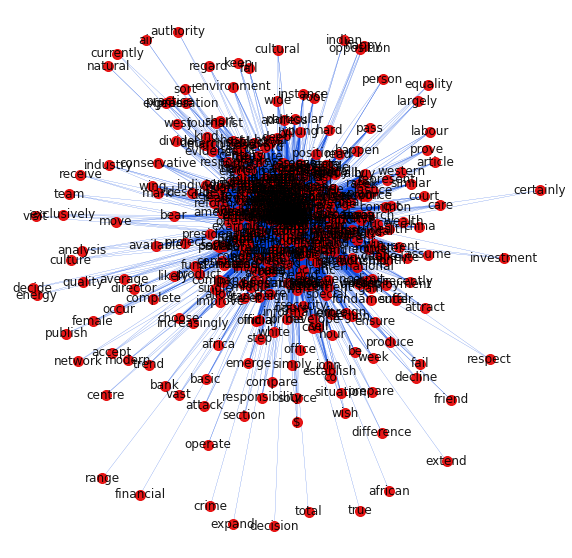

In [104]:
layout = nx.spring_layout(giant, weight='weight', iterations= 50)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:red",
        edge_color='xkcd:blue')

In [91]:
nowDF

,textID,texts,year,kmeans_predictions,tokenized_text,normalized_tokens,reduced_tokens
0,1522186,"By Dale T. McKinley , Johannesburg June 15 ...",2010,3,"[By, Dale, T., McKinley, Johannesburg, June, 1...","[dale, t., mckinley, johannesburg, june, offer...","[june, offer, public, cup, collective, positiv..."
1,1525218,Julia Gillard Is Julia Gillard a conviction...,2010,3,"[Julia, Gillard, Is, Julia, Gillard, a, convic...","[julia, gillard, julia, gillard, conviction, p...","[simply, political, recent, centre, prime, min..."
2,1536821,If you 've been dead from the neck up this pa...,2010,1,"[If, you, ve, been, dead, from, the, neck, up,...","[have, dead, neck, past, week, come, shock, le...","[past, week, come, learn, australia, female, p..."
3,1541120,""" The MDC roots were in the popular challenge...",2010,3,"[The, MDC, roots, were, in, the, popular, chal...","[mdc, root, popular, challenge, zanu, pf, late...","[popular, challenge, late, movement, rest, jun..."
4,1520188,New Bedford - A law firm ran an ad for a fore...,2010,3,"[New, Bedford, A, law, firm, ran, an, ad, for,...","[new, bedford, law, firm, run, ad, foreclose, ...","[law, run, property, recently, state, white, p..."
...,...,...,...,...,...,...,...
23,1536188,After the Kyoto protocol and the IPCC report ...,2010,1,"[After, the, Kyoto, protocol, and, the, IPCC, ...","[kyoto, protocol, ipcc, report, climate, chang...","[report, climate, change, issue, face, climate..."
24,1536872,As the final phase of the intake of OBCs quot...,2010,3,"[As, the, final, phase, of, the, intake, of, O...","[final, phase, intake, obcs, quota, educationa...","[educational, central, university, fund, centr..."
25,1539693,Though economic liberalisation in India can b...,2010,1,"[Though, economic, liberalisation, in, India, ...","[economic, liberalisation, india, trace, late,...","[india, late, reform, july, service, state, ma..."
26,1532708,President Pratibha Devsingh Patil has said th...,2010,3,"[President, Pratibha, Devsingh, Patil, has, sa...","[president, pratibha, devsingh, patil, say, ge...","[president, say, generation, knowledge, cultur..."


In [92]:
dool = nowDF['tokenized_text'][0]
dool

0    [By, Dale, T., McKinley, Johannesburg, June, 1...
0    [By, Dale, T., McKinley, Johannesburg, June, 1...
Name: tokenized_text, dtype: object

In [93]:
all_texts = nowDF['normalized_tokens'].sum()

In [94]:
all_texts = [all_texts]

In [95]:
all_texts

[['dale',
  't.',
  'mckinley',
  'johannesburg',
  'june',
  'offer',
  'unapologetic',
  'public',
  'critique',
  'fifa',
  'soccer',
  'world',
  'cup',
  'height',
  'collective',
  'frenzy',
  'positive',
  'expectation',
  'feel',
  'good',
  'nationalism',
  'general',
  'public',
  'excitement',
  'exist',
  'country',
  'risky',
  'thing',
  'risk',
  'need',
  'take',
  'precisely',
  'matt',
  'context',
  'myth',
  'need',
  'separate',
  'reality',
  'case',
  'great',
  'earth',
  'leave',
  'aside',
  'real',
  'beauty',
  'enjoyment',
  'game',
  'soccer',
  'myth',
  'make',
  'create',
  'situation',
  'akin',
  'inhale',
  'tik',
  'short',
  'live',
  'high',
  'euphoria',
  'obscure',
  'reality',
  'follow',
  'rapid',
  'depress',
  'come',
  'reality',
  'start',
  'point',
  'mythology',
  'build',
  'world',
  'cup',
  'misplace',
  'assumption',
  'mega',
  'event',
  'case',
  'sport',
  'benefit',
  'thing',
  'government',
  'fifa',
  'mention',
  'bevy',

In [101]:
dictionary = gensim.corpora.Dictionary(all_texts)
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, \
                id2word=dictionary, num_topics=6, alpha='auto', eta='auto')

In [102]:
doollda.show_topics()

[(0,
  '0.006*"people" + 0.005*"say" + 0.005*"world" + 0.004*"year" + 0.004*"woman" + 0.004*"state" + 0.004*"government" + 0.004*"work" + 0.003*"new" + 0.003*"time"'),
 (1,
  '0.005*"woman" + 0.004*"people" + 0.004*"state" + 0.003*"year" + 0.003*"time" + 0.003*"say" + 0.003*"change" + 0.003*"country" + 0.003*"social" + 0.003*"world"'),
 (2,
  '0.005*"world" + 0.005*"people" + 0.004*"government" + 0.004*"woman" + 0.004*"say" + 0.004*"year" + 0.003*"state" + 0.003*"country" + 0.003*"time" + 0.003*"new"'),
 (3,
  '0.004*"people" + 0.004*"time" + 0.004*"world" + 0.004*"state" + 0.004*"government" + 0.004*"country" + 0.004*"work" + 0.003*"year" + 0.003*"social" + 0.003*"say"'),
 (4,
  '0.005*"world" + 0.004*"people" + 0.004*"year" + 0.003*"say" + 0.003*"work" + 0.003*"government" + 0.003*"state" + 0.003*"time" + 0.003*"woman" + 0.003*"economic"'),
 (5,
  '0.006*"people" + 0.005*"world" + 0.004*"work" + 0.004*"year" + 0.004*"country" + 0.004*"woman" + 0.003*"change" + 0.003*"state" + 0.003*"